# Clustering Neighborhoods Toronto Capstone Project

## Introduction

The project is to explore and cluster the neighborhoods in Toronto. In this project, we will mainly focus on how to scrape a webpage and manipulate the given dataframe, how to convert neighborhoods into their equivalent latitude and longitude values, as well as the visualization of clustering (neighborhoods). 

We'll use Foursquare API, Google GeoCoder to explore the neighborhoods and segment them. 

We'll run K-mean algorithm to cluster the neighborhoods and examine the clusters. 



## To scrape a webpage and manipulate the dataframe and do visualization

Import the packages for this project

In [85]:
# import packages and mainly use bs4 function to perform the task.

# import urllib
# from urllib.request import urlopen
from bs4 import BeautifulSoup

import os,sys

In [86]:
import pandas as pd # library for data analsysis
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [87]:
target_URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [88]:
# scrape the webpage and form a dataframe

html_doc = requests.get(target_URL).text
soup = BeautifulSoup(html_doc, 'html.parser')

wikitables = soup.find_all('table') 
df = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]

print(df.shape)
df.head()

(288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [89]:
# to ignore cells with a borough that is Not assigned

new_df = df[ ~ df['Borough'].str.contains('Not assigned')]      
# new_df = df[df.Borough != 'Not assigned']   

print(new_df.shape)
new_df.head()

(211, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


For different purpose, we my combine the neighborhoods on the same row level if they have a same name of borough.

In [90]:
# using groupby and aggregated function and using comma as to separate the combined values. 

# dfps = new_df.groupby(['Postcode','Borough'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ', '.join(x))
# print(dfps.shape)
# dfps.tail()

We don't want "Not assigned" as a value appeared in out dataset, so we do some change. 

In [91]:
#  to replace "Not assigned" in column 'Neighbourhood' with the value in 'Borough'.

for i in range(len(new_df)):
    dat_line=new_df.iloc[i,:]
    if dat_line['Neighbourhood'] == 'Not assigned':
        dat_line['Neighbourhood'] = dat_line['Borough']

In [92]:
# check and verify if updated correctly. 

new_df.iloc[6,:]

Postcode                  M7A
Borough          Queen's Park
Neighbourhood    Queen's Park
Name: 8, dtype: object

In [93]:
# display the dataset 

print(new_df.shape)
new_df.head()

(211, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights



**To get the latitude and the longitude coordinates of each neighborhood**

In [94]:
# we use the given file to obtain the information. 

geo_df = pd.read_csv("Geospatial_Coordinates.csv")
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [95]:
# to change the 1st column name as to match the previous dataset.

geo_df.rename(columns={'Postal Code':'Postcode'}, inplace = True)
geo_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [96]:
# merge the two related datasets and form a new dataframe.

new_df1 = pd.merge(new_df, geo_df, on='Postcode')
new_df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [97]:
# for convenient, we unify the column name

new_df1.rename(columns={'Neighbourhood':'Neighborhood'}, inplace = True)
new_df1.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [98]:
# print out the total boroughs and the neighborhoods associated with 

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(new_df1['Borough'].unique()),
        new_df1.shape[0]
    )
)

The dataframe has 11 boroughs and 211 neighborhoods.



**Use geopy library to get the latitude and longitude values of Toronto and to visualize the neighborhoods and see how they cluster together**

In [99]:
##  to find the latitude & longitude of the city of Toronto.

from geopy.geocoders import Nominatim

address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

C:\Users\bista\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  import sys


The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [16]:
# Optional block...
## In case of the Geocoder Python package unreliable... then run the following:

latitude=43.653963
longitude=-79.387207
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [100]:
#!conda install -c conda-forge folium=0.7.0 --yes 
import folium # map rendering librarypd.set_option('display.max_rows', None)

In [101]:
# create map of Toronto using latitude and longitude values

map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_df1['Latitude'], new_df1['Longitude'], new_df1['Borough'], new_df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Toronto)  
    
map_Toronto

In [102]:
# We may simplify the above map and segment and cluster only the neighborhoods in Toronto. 
## let's slice the dataframe from "new_df1" and create a new dataframe of the downtown area data.

downtown_data = new_df1[new_df1['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


**Get the geographical coordinates of North York (Toronto, Canada)**

In [103]:
address = 'Downtown, Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of Downtown Toronto (Ontario, Canada) are {}, {}.'.format(latitude1, longitude1))

C:\Users\bista\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Downtown Toronto (Ontario, Canada) are 43.6541737, -79.3808116451341.


This time we will be plotting the data points (Downtown Toronto area) onto a Leaflet map so we define a function 

In [104]:
def plot_points( lats, lngs , radii=[], colors=[], labels=[], opacities=[], toner=False,zoom=12, prev_map= None):
    
    pt_amt= len( lats )
    
    # check initial conditions    
    make_popups= lambda labels: [ folium.Popup( l, parse_html=True) for l in labels ] \
                                if len( labels ) == pt_amt \
                                else [None] * pt_amt
    check_radii= lambda radii: radii if len( radii ) == pt_amt else [1] * pt_amt
    check_colors= lambda colors: colors if len( colors ) == pt_amt else ['black'] * pt_amt
    check_opacities= lambda opacities: opacities if len( opacities ) == pt_amt else [1] * pt_amt
    
    popups= make_popups( labels )
    radii= check_radii( radii )
    colors= check_colors( colors )
    opacities= check_opacities( opacities )
    
    # if there was no previous map make a new one
    if prev_map == None:
        center= [ lats.mean(), lngs.mean() ]
        tiles= 'Stamen Toner' if toner else 'OpenStreetMap'
        prev_map= folium.Map( location=center, zoom_start=zoom, control_scale=True, tiles=tiles)
        
    for lat, lng, r, color, op, popup in zip(lats, lngs, radii, colors, opacities, popups):
        folium.Circle(
            location=[lat,lng],
            radius=r,
            color=color,
            popup= popup,
            fill=True,
            fill_color=color,
            fill_opacity=op
        ).add_to(prev_map)

    return prev_map

In [105]:
# create map of North York using the latitude1 and longitude1 values.. and plotting onto a Leaflet map

downtown_toronto= downtown_data.shape[0]

# make yellow circles signifying the effective radius of each tutoring services
area_map= plot_points( downtown_data.Latitude, 
                         downtown_data.Longitude,
                         [650] * downtown_toronto,
                         ['orange'] * downtown_toronto,
                         opacities= [0.1] * downtown_toronto )

# add the tutoring services to the map
downtown_hood= plot_points( downtown_data.Latitude, 
                         downtown_data.Longitude,
                         [100] * downtown_toronto,
                         ['darkblue'] * downtown_toronto, 
                         downtown_data.Neighborhood, 
                         prev_map=area_map )


map_downtown = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        #color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_downtown)  
    
map_downtown.add_to(downtown_hood)

## We now utilize Foursquare API to explore the neighborhoods and segment them.

In [106]:
CLIENT_ID = '2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN' # your Foursquare ID
CLIENT_SECRET = 'MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY' # your Foursquare Secret
VERSION = '20181210'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN
CLIENT_SECRET:MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY


Use the first "neighborhood" as a data point to initialize..

In [107]:
new_df1.loc[0, 'Neighborhood']

'Parkwoods'

In [108]:
neighborhood_latitude = new_df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = new_df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = new_df1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [109]:
# create the GET request URL

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=2FLVJND5JYKT0PVG3F34I4KSAETJPLWXERDAJ0TSPJLASEAN&client_secret=MF21TJHE3CV4LDVMOXE4ZE3U4VPYHWGF44L1GTXRE33PHIEY&v=20181210&ll=43.7532586,-79.3296565&radius=500&limit=100'

Send the GET request and examine the resutls

In [110]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d4ca468bf7dde002cfc5ac6'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

Create a function which extracts the category of the venue

In [111]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [112]:
# clean the json and structure it into a pandas dataframe.

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [113]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


To create a function to repeat the same process but to ALL of the neighborhoods

In [114]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [115]:
##  new_df1.drop('Postcode',axis=1,inplace = True)
new_df1.head(2)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572


To execute the function above and to form a new dataframe.

In [116]:
toronto_venues = getNearbyVenues(names=new_df1['Neighborhood'],
                                   latitudes=new_df1['Latitude'],
                                   longitudes=new_df1['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [117]:
print(toronto_venues.shape)
toronto_venues.head()

(4463, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


We now slice the venue of "hotel" out of Toronto venues.

In [118]:
filter = toronto_venues['Venue Category']=='Hotel'
toronto_hotel = toronto_venues.loc[filter]
print(len(toronto_hotel))
toronto_hotel.head()

77


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
49,Harbourfront,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
96,Regent Park,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
228,Ryerson,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
328,Garden District,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
489,St. James Town,43.651494,-79.375418,Cambridge Suites Toronto,43.651836,-79.378107,Hotel


In [119]:
# use "groupby" and count the total number of venues for each of neighborhoods.

toronto_venues.groupby('Neighborhood').count()[:10]

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Agincourt North,3,3,3,3,3,3
Albion Gardens,10,10,10,10,10,10
Alderwood,10,10,10,10,10,10
Bathurst Manor,19,19,19,19,19,19
Bathurst Quay,16,16,16,16,16,16
Bayview Village,4,4,4,4,4,4
Beaumond Heights,10,10,10,10,10,10


In [120]:
# one hot encoding
toronto_venue_data = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_venue_data['Neighborhood'] = toronto_venues['Neighborhood'] 

# fixed_columns = [toronto_venue_data.columns[-1]] + list(toronto_venue_data.columns[:-1])
# toronto_venue_data = toronto_venue_data[fixed_columns]

print('the shape of toronto venues:',toronto_venue_data.shape)

cols = list(toronto_venue_data)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))

TVD=toronto_venue_data[cols]
print(TVD.shape)
TVD.head()

the shape of toronto venues: (4463, 279)
(4463, 279)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,

In [121]:
# similarly we repeat the process and get toronto hotel data

toronto_hotel_data = pd.get_dummies(toronto_hotel[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_hotel_data['Neighborhood'] = toronto_hotel['Neighborhood'] 

# move neighborhood column to the first column
# fixed_columns = [toronto_venue_data.columns[-1]] + list(toronto_venue_data.columns[:-1])
# toronto_venue_data = toronto_venue_data[fixed_columns]

toronto_hotel_data[:10]

,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,DoubleTree by Hilton Hotel Toronto Downtown,Gecko Hospitality,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Anndore House,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites,Neighborhood
49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Harbourfront
96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Regent Park
228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Ryerson
328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Garden District
489,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. James Town
495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,St. James Town
525,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. James Town
550,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,St. James Town
554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,St. James Town
674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Berczy Park


In [122]:
# repeat the process..

cols1 = list(toronto_hotel_data)

# move the column to head of list using index, pop and insert
cols1.insert(0, cols1.pop(cols1.index('Neighborhood')))
# len(cols1)

THD=toronto_hotel_data[cols1]
THD.head()

,Neighborhood,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,DoubleTree by Hilton Hotel Toronto Downtown,Gecko Hospitality,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Anndore House,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites
49,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
96,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
228,Ryerson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
328,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
489,St. James Town,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
# try to find some the luxury hotels and their neighborhoods

lux_hotel=THD[['Neighborhood','Shangri-La Toronto','The Fairmont Royal York']]
print(lux_hotel.shape[0])
A1=(lux_hotel['The Fairmont Royal York']==1)
royal=lux_hotel.loc[A1]
print(royal)
A=(lux_hotel['Shangri-La Toronto']==1)
shangri=lux_hotel.loc[A]
print(shangri[:10])

77
                 Neighborhood  Shangri-La Toronto  The Fairmont Royal York
2013          Design Exchange                   0                        1
2113  Toronto Dominion Centre                   0                        1
2378           Commerce Court                   0                        1
2478           Victoria Hotel                   0                        1
4096     First Canadian Place                   0                        1
4196         Underground city                   0                        1
                 Neighborhood  Shangri-La Toronto  The Fairmont Royal York
930                  Adelaide                   1                        0
1030                     King                   1                        0
1130                 Richmond                   1                        0
2064          Design Exchange                   1                        0
2164  Toronto Dominion Centre                   1                        0
4094     First Canadia

**let's group rows by neighborhood (both on "Toronto hotel data" and "Toronto venue data") and by taking the mean of the frequency of occurrence of each category**

In [126]:
hotel_grouped = THD.groupby('Neighborhood').mean().reset_index()
print(hotel_grouped.shape)
hotel_grouped.head()

(25, 25)


,Neighborhood,Best Western Roehampton Hotel & Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre West,Delta Hotels by Marriott Toronto,DoubleTree by Hilton Hotel Toronto Downtown,Gecko Hospitality,Hilton Garden Inn,Hilton Toronto,InterContinental Toronto Centre,Le Germain Hotel Toronto Maple Leaf Square,Novotel Toronto North York,One King West Hotel & Residence,Radisson Admiral Hotel Toronto-Harbourfront,Residence & Conference Centre,Shangri-La Toronto,The Adelaide Hotel Toronto,The Anndore House,The Fairmont Royal York,The Grand Hotel & Suites Toronto,The Omni King Edward Hotel,The Ritz-Carlton Toronto,"The Westin Harbour Castle, Toronto",Town Inn Suites
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Canada Post Gateway Processing Centre,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Church and Wellesley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.5


In [127]:
toronto_grouped = TVD.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(207, 279)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0

**Print each neighborhood along with the top 10 most common venues**

In [128]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2           Steakhouse  0.04
3                  Bar  0.04
4      Thai Restaurant  0.04
5         Burger Joint  0.03
6       Breakfast Spot  0.03
7                  Gym  0.03
8  American Restaurant  0.03
9                Hotel  0.03


----Agincourt----
                        venue  freq
0              Breakfast Spot  0.25
1                      Lounge  0.25
2              Clothing Store  0.25
3                Skating Rink  0.25
4   Middle Eastern Restaurant  0.00
5          Miscellaneous Shop  0.00
6           Mobile Phone Shop  0.00
7  Modern European Restaurant  0.00
8          Mexican Restaurant  0.00
9                  Nail Salon  0.00


----Agincourt North----
                             venue  freq
0                       Playground  0.33
1                      Coffee Shop  0.33
2                             Park  0.33
3                Accessories Store  0.00
4  Molecular Gast

                      venue  freq
0               Coffee Shop  0.07
1       Japanese Restaurant  0.06
2          Sushi Restaurant  0.05
3                Restaurant  0.04
4                   Gay Bar  0.04
5                      Café  0.02
6                 Gastropub  0.02
7  Mediterranean Restaurant  0.02
8                       Gym  0.02
9               Men's Store  0.02


----Clairlea----
                  venue  freq
0              Bus Line  0.22
1                Bakery  0.22
2           Bus Station  0.11
3          Soccer Field  0.11
4  Fast Food Restaurant  0.11
5                  Park  0.11
6          Intersection  0.11
7   Monument / Landmark  0.00
8           Music Store  0.00
9                Museum  0.00


----Clarks Corners----
                  venue  freq
0           Pizza Place  0.17
1    Chinese Restaurant  0.08
2   Fried Chicken Joint  0.08
3       Thai Restaurant  0.08
4          Noodle House  0.08
5    Italian Restaurant  0.08
6         Shopping Mall  0.08
7           

                             venue  freq
0                   Discount Store  0.33
1                 Department Store  0.17
2               Chinese Restaurant  0.17
3                      Coffee Shop  0.17
4                Convenience Store  0.17
5                Mobile Phone Shop  0.00
6       Modern European Restaurant  0.00
7  Molecular Gastronomy Restaurant  0.00
8              Monument / Landmark  0.00
9                            Motel  0.00


----East Toronto----
                             venue  freq
0                             Park  0.50
1                      Pizza Place  0.25
2                Convenience Store  0.25
3       Modern European Restaurant  0.00
4                      Music Store  0.00
5                           Museum  0.00
6                    Movie Theater  0.00
7                            Motel  0.00
8              Monument / Landmark  0.00
9  Molecular Gastronomy Restaurant  0.00


----Emery----
                             venue  freq
0                 

                     venue  freq
0           History Museum  0.33
1                      Bar  0.33
2              Golf Course  0.33
3  New American Restaurant  0.00
4              Music Venue  0.00
5              Music Store  0.00
6                   Museum  0.00
7            Movie Theater  0.00
8                    Motel  0.00
9      Monument / Landmark  0.00


----Hillcrest Village----
                      venue  freq
0                   Dog Run   0.2
1  Mediterranean Restaurant   0.2
2                      Pool   0.2
3      Fast Food Restaurant   0.2
4               Golf Course   0.2
5                     Motel   0.0
6               Music Venue   0.0
7               Music Store   0.0
8                    Museum   0.0
9             Movie Theater   0.0


----Humber Bay----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Pool  0.33
2              Baseball Field  0.33
3           Accessories Store  0.00
4         Monument / Landmark  0.0

                    venue  freq
0       Convenience Store  0.08
1                     Gym  0.08
2             Social Club  0.08
3    Fast Food Restaurant  0.08
4          Sandwich Place  0.08
5         Supplement Shop  0.08
6            Burger Joint  0.08
7          Discount Store  0.08
8  Thrift / Vintage Store  0.08
9           Grocery Store  0.08


----L'Amoreaux East----
                             venue  freq
0                       Playground  0.33
1                      Coffee Shop  0.33
2                             Park  0.33
3                Accessories Store  0.00
4  Molecular Gastronomy Restaurant  0.00
5                      Music Venue  0.00
6                      Music Store  0.00
7                           Museum  0.00
8                    Movie Theater  0.00
9                            Motel  0.00


----L'Amoreaux West----
                  venue  freq
0    Chinese Restaurant  0.15
1  Fast Food Restaurant  0.15
2           Coffee Shop  0.15
3            Nail Salon  

                             venue  freq
0                   Discount Store  0.25
1                       Restaurant  0.25
2                      Coffee Shop  0.25
3                   Sandwich Place  0.25
4        Middle Eastern Restaurant  0.00
5               Miscellaneous Shop  0.00
6                Mobile Phone Shop  0.00
7       Modern European Restaurant  0.00
8  Molecular Gastronomy Restaurant  0.00
9              Monument / Landmark  0.00


----Mount Olive----
                  venue  freq
0         Grocery Store   0.2
1           Pizza Place   0.2
2              Pharmacy   0.1
3  Fast Food Restaurant   0.1
4            Beer Store   0.1
5        Sandwich Place   0.1
6           Coffee Shop   0.1
7   Fried Chicken Joint   0.1
8   Monument / Landmark   0.0
9           Music Store   0.0


----New Toronto----
                  venue  freq
0           Flower Shop  0.07
1                Bakery  0.07
2              Pharmacy  0.07
3            Restaurant  0.07
4        Sandwich Place  

                             venue  freq
0                             Park  0.25
1                      Pizza Place  0.25
2                Mobile Phone Shop  0.25
3                         Bus Line  0.25
4  Molecular Gastronomy Restaurant  0.00
5                      Music Store  0.00
6                           Museum  0.00
7                    Movie Theater  0.00
8                            Motel  0.00
9              Monument / Landmark  0.00


----Riverdale----
                     venue  freq
0         Greek Restaurant  0.22
1              Coffee Shop  0.10
2       Italian Restaurant  0.07
3           Ice Cream Shop  0.07
4   Furniture / Home Store  0.05
5  Fruit & Vegetable Store  0.02
6                Bookstore  0.02
7               Sports Bar  0.02
8                  Brewery  0.02
9              Pizza Place  0.02


----Roncesvalles----
                         venue  freq
0               Breakfast Spot  0.13
1                    Gift Shop  0.13
2                Movie Theater  

                             venue  freq
0                       Playground  0.33
1                      Coffee Shop  0.33
2                             Park  0.33
3                Accessories Store  0.00
4  Molecular Gastronomy Restaurant  0.00
5                      Music Venue  0.00
6                      Music Store  0.00
7                           Museum  0.00
8                    Movie Theater  0.00
9                            Motel  0.00


----Stn A PO Boxes 25 The Esplanade----
                  venue  freq
0           Coffee Shop  0.11
1                  Café  0.04
2            Restaurant  0.04
3                 Hotel  0.03
4  Fast Food Restaurant  0.03
5          Cocktail Bar  0.03
6              Beer Bar  0.03
7    Seafood Restaurant  0.03
8                Bakery  0.03
9   Japanese Restaurant  0.02


----Studio District----
                     venue  freq
0                     Café  0.10
1              Coffee Shop  0.08
2       Italian Restaurant  0.05
3                Ga

                 venue  freq
0          Coffee Shop  0.11
1                Hotel  0.05
2             Aquarium  0.05
3                 Café  0.04
4   Italian Restaurant  0.04
5              Brewery  0.03
6          Pizza Place  0.03
7  Sporting Goods Shop  0.03
8       Scenic Lookout  0.03
9               Bakery  0.03


----Trinity----
                     venue  freq
0                      Bar  0.11
1              Coffee Shop  0.06
2         Asian Restaurant  0.05
3                     Café  0.03
4        French Restaurant  0.03
5  New American Restaurant  0.03
6               Restaurant  0.03
7                   Bakery  0.03
8              Pizza Place  0.03
9    Vietnamese Restaurant  0.03


----Underground city----
              venue  freq
0       Coffee Shop  0.09
1              Café  0.07
2        Restaurant  0.04
3        Steakhouse  0.04
4             Hotel  0.04
5     Deli / Bodega  0.03
6               Bar  0.03
7         Gastropub  0.03
8  Asian Restaurant  0.03
9            

                    venue  freq
0    Caribbean Restaurant  0.14
1      Miscellaneous Shop  0.14
2          Massage Studio  0.14
3                     Bar  0.14
4      Falafel Restaurant  0.14
5  Furniture / Home Store  0.14
6             Coffee Shop  0.14
7                  Museum  0.00
8              Nail Salon  0.00
9             Music Venue  0.00


----Yorkville----
            venue  freq
0            Café  0.12
1  Sandwich Place  0.12
2     Coffee Shop  0.12
3     Pizza Place  0.08
4  Cosmetics Shop  0.04
5             Pub  0.04
6     Flower Shop  0.04
7    Liquor Store  0.04
8    Burger Joint  0.04
9       BBQ Joint  0.04




In [129]:
# Print each neighborhood along with the top 3 hotels

num_top_venues = 3

for hood in hotel_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = hotel_grouped[hotel_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                        venue  freq
0              Hilton Toronto  0.33
1  The Adelaide Hotel Toronto  0.33
2          Shangri-La Toronto  0.33


----Berczy Park----
                                    venue  freq
0      The Westin Harbour Castle, Toronto   1.0
1  Best Western Roehampton Hotel & Suites   0.0
2                Cambridge Suites Toronto   0.0


----Canada Post Gateway Processing Centre----
                                               venue  freq
0  Courtyard Mississauga-Airport Corporate Centre...   0.5
1                                  Hilton Garden Inn   0.5
2             Best Western Roehampton Hotel & Suites   0.0


----Central Bay Street----
                                         venue  freq
0  DoubleTree by Hilton Hotel Toronto Downtown   1.0
1       Best Western Roehampton Hotel & Suites   0.0
2  Radisson Admiral Hotel Toronto-Harbourfront   0.0


----Church and Wellesley----
                      venue  freq
0           Town Inn Suites   0.5
1

For convenient, let's define it as a function

In [130]:

def top_venues(hood, num):
    num_top_venues = num
    
  #  for hood in toronto_grouped['Neighborhood']:

    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
        
    top_venues=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
        # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        # print('\n')
        
    return top_venues

Check some samples(by neighborhood and on 'hotel')...

In [131]:
sample1=top_venues('First Canadian Place',100)
filter=sample1['venue']=='Hotel'
sample1.loc[filter]

,venue,freq
4,Hotel,0.04


In [132]:
sample2=top_venues('Toronto Dominion Centre',100)
filter=sample2['venue']=='Hotel'
sample2.loc[filter]

,venue,freq
2,Hotel,0.06


In [133]:
sample3=top_venues('Design Exchange',100)
filter=sample3['venue']=='Hotel'
sample3.loc[filter]

,venue,freq
2,Hotel,0.06


In [134]:
print(toronto_hotel.shape)
toronto_hotel.head()

(77, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
49,Harbourfront,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
96,Regent Park,43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
228,Ryerson,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
328,Garden District,43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
489,St. James Town,43.651494,-79.375418,Cambridge Suites Toronto,43.651836,-79.378107,Hotel


## Create a function to sort the venues in descending order.

In [135]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [136]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Burger Joint,Restaurant,Gym
1,Agincourt,Clothing Store,Breakfast Spot,Lounge,Skating Rink,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,Agincourt North,Playground,Park,Coffee Shop,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
3,Albion Gardens,Pizza Place,Grocery Store,Fried Chicken Joint,Pharmacy,Coffee Shop,Sandwich Place,Beer Store,Fast Food Restaurant,Golf Course,Gluten-free Restaurant
4,Alderwood,Pizza Place,Athletics & Sports,Coffee Shop,Pool,Pub,Sandwich Place,Skating Rink,Pharmacy,Gym,Dive Bar


In [137]:
print('Shape of Neighborhood Sorted-Venues:', neighborhoods_venues_sorted.shape)
print('Shape of Toronto Groups:', toronto_grouped.shape)

Shape of Neighborhood Sorted-Venues: (207, 11)
Shape of Toronto Groups: (207, 279)


In [138]:
# create the new dataframe and display the top 5 hotels for each neighborhood.

num_hotels = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_hotels):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_hotels_sorted = pd.DataFrame(columns=columns)
neighborhoods_hotels_sorted['Neighborhood'] = hotel_grouped['Neighborhood']

for ind in np.arange(hotel_grouped.shape[0]):
    neighborhoods_hotels_sorted.iloc[ind, 1:] = return_most_common_venues(hotel_grouped.iloc[ind, :], num_hotels)

neighborhoods_hotels_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
1,Berczy Park,"The Westin Harbour Castle, Toronto",Town Inn Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
2,Canada Post Gateway Processing Centre,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto
3,Central Bay Street,DoubleTree by Hilton Hotel Toronto Downtown,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
4,Church and Wellesley,Town Inn Suites,The Anndore House,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


## Cluster Neighborhoods
**Run k-means to cluster the neighborhood into 10 clusters**

In [139]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 9, 1, 1, 1, 6, 1, 1, 1])

In [140]:
# set number of clusters for hotel
k_clusters = 5

hotel_grouped_clustering = hotel_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_hotel = KMeans(n_clusters=k_clusters, random_state=0).fit(hotel_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_hotel.labels_[0:5] 

array([1, 0, 0, 0, 0])

**Create a new dataframe that includes the cluster as well as the top 10 venues (or 5 for hotel) for each neighborhood**

In [141]:
new_df1.drop('Postcode',axis=1,inplace = True)
new_df1.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,Downtown Toronto,Regent Park,43.654260,-79.360636
4,North York,Lawrence Heights,43.718518,-79.464763


In [142]:
new_tab = toronto_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
new_tab.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,43.753259,-79.329656
1,Parkwoods,43.753259,-79.329656
2,Parkwoods,43.753259,-79.329656
3,Victoria Village,43.725882,-79.315572
4,Victoria Village,43.725882,-79.315572


In [143]:
# unify the column name

new_tab.rename(columns={'Neighborhood Latitude':'Latitude'}, inplace = True)
new_tab.rename(columns={'Neighborhood Longitude':'Longitude'}, inplace = True)
new_tab.head()

C:\Users\bista\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Latitude,Longitude
0,Parkwoods,43.753259,-79.329656
1,Parkwoods,43.753259,-79.329656
2,Parkwoods,43.753259,-79.329656
3,Victoria Village,43.725882,-79.315572
4,Victoria Village,43.725882,-79.315572


In [144]:
# left JOIN using 'merge'

new_df2 = pd.merge(new_tab, new_df1, how='left', on=['Neighborhood', 'Latitude', 'Longitude'])
new_df2.head()

,Neighborhood,Latitude,Longitude,Borough
0,Parkwoods,43.753259,-79.329656,North York
1,Parkwoods,43.753259,-79.329656,North York
2,Parkwoods,43.753259,-79.329656,North York
3,Victoria Village,43.725882,-79.315572,North York
4,Victoria Village,43.725882,-79.315572,North York


In [145]:
# move the column to head of list using index, pop and insert
col = list(new_df2)

col.insert(0, col.pop(col.index('Borough')))

tor_df = new_df2[col]
print(tor_df.shape)
tor_df.head()

(4463, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Parkwoods,43.753259,-79.329656
2,North York,Parkwoods,43.753259,-79.329656
3,North York,Victoria Village,43.725882,-79.315572
4,North York,Victoria Village,43.725882,-79.315572


In [146]:
# extract the unique values from 'neighborhood'

staging1 = pd.DataFrame(tor_df.Neighborhood.unique())
print(len(staging1))
staging1.head()

207


,0
0,Parkwoods
1,Victoria Village
2,Harbourfront
3,Regent Park
4,Lawrence Heights


In [147]:
# add clustering labels

toronto_merged = staging1

toronto_merged['Cluster Labels'] = kmeans.labels_

# toronto_merged.rename(columns={'':'Neighborhood'}, inplace = True)
toronto_merged.columns = ['Neighborhood','Cluster Labels']
toronto_merged.head()

,Neighborhood,Cluster Labels
0,Parkwoods,1
1,Victoria Village,1
2,Harbourfront,9
3,Regent Park,1
4,Lawrence Heights,1


In [148]:
# combine with the primary dataframe using 'merge'

new_merged = pd.merge(new_df1, toronto_merged, how='left', on=['Neighborhood'])
# new_merged['Cluster Labels'] = new_merged['Cluster Labels'].astype(int)
new_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,North York,Parkwoods,43.753259,-79.329656,1.0
1,North York,Victoria Village,43.725882,-79.315572,1.0
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,9.0
3,Downtown Toronto,Regent Park,43.654260,-79.360636,1.0
4,North York,Lawrence Heights,43.718518,-79.464763,1.0


In [149]:
# check if there is any null values

new_merged['Cluster Labels'].isnull().any()

True

In [150]:
# drop those null values

new_merged.dropna(axis=0,inplace=True)

In [151]:
# convert the cluster labels as "int"
new_merged['Cluster Labels'] = new_merged['Cluster Labels'].astype(int)
print(new_merged.shape)
new_merged[:10]

(209, 5)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,North York,Parkwoods,43.753259,-79.329656,1
1,North York,Victoria Village,43.725882,-79.315572,1
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,9
3,Downtown Toronto,Regent Park,43.654260,-79.360636,1
4,North York,Lawrence Heights,43.718518,-79.464763,1
5,North York,Lawrence Manor,43.718518,-79.464763,1
6,Queen's Park,Queen's Park,43.662301,-79.389494,6
8,Scarborough,Rouge,43.806686,-79.194353,1
9,Scarborough,Malvern,43.806686,-79.194353,1
10,North York,Don Mills North,43.745906,-79.352188,1


Repeat the process for the object of "hotel"

In [152]:
# # add clustering labels to the object of 'hotel'

hotel_grouped['Cluster Labels'] = kmeans_hotel.labels_

hotel_merged = hotel_grouped[['Neighborhood','Cluster Labels']]
hotel_merged.head(2)

,Neighborhood,Cluster Labels
0,Adelaide,1
1,Berczy Park,0


In [153]:
# hotel merged
new_d = new_merged[['Borough','Neighborhood','Latitude','Longitude']]
new_hotel_merged = pd.merge(hotel_merged, new_d, how='left', on=['Neighborhood'])
new_hotel_merged=new_hotel_merged[['Borough','Neighborhood','Latitude','Longitude','Cluster Labels']]
print(new_hotel_merged.shape)
new_hotel_merged.head()

(26, 5)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Downtown Toronto,Adelaide,43.650571,-79.384568,1
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,0
2,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0
3,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0
4,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0


In [154]:
new_hotel_merged['Cluster Labels'].isnull().any()

False

In [155]:
# merge to sorted venue data to get a new dataframe

new_merged = new_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(new_merged.shape)
new_merged.head() 

(209, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,1,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,North York,Victoria Village,43.725882,-79.315572,1,Intersection,Hockey Arena,Portuguese Restaurant,Coffee Shop,Yoga Studio,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,9,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Mexican Restaurant,Brewery,Shoe Store
3,Downtown Toronto,Regent Park,43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Mexican Restaurant,Brewery,Shoe Store
4,North York,Lawrence Heights,43.718518,-79.464763,1,Women's Store,Furniture / Home Store,Athletics & Sports,Event Space,Miscellaneous Shop,Coffee Shop,Clothing Store,Boutique,Accessories Store,Vietnamese Restaurant


In [156]:
# for hotel

new_hotel_merged = new_hotel_merged.join(neighborhoods_hotels_sorted.set_index('Neighborhood'), on='Neighborhood')

print(new_hotel_merged.shape)
new_hotel_merged.head()

(26, 10)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Downtown Toronto,Adelaide,43.650571,-79.384568,1,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,"The Westin Harbour Castle, Toronto",Town Inn Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
2,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto
3,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,DoubleTree by Hilton Hotel Toronto Downtown,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
4,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Town Inn Suites,The Anndore House,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


In [157]:
print(new_merged['Cluster Labels'].unique())
print(new_hotel_merged['Cluster Labels'].unique())

[1 9 6 2 7 3 0 4 8 5]
[1 0 4 3 2]


### Visualize the resulting clusters (10)

In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_merged['Latitude'], new_merged['Longitude'], new_merged['Neighborhood'], new_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [159]:
# visualize the resulting clusters for the object of hotel

hotel_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

k_clusters = 5
# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_hotel_merged['Latitude'], new_hotel_merged['Longitude'], new_hotel_merged['Neighborhood'], new_hotel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(hotel_clusters)
       
hotel_clusters

## Examine Clusters

In [160]:
## Cluster 1

new_merged.loc[new_merged['Cluster Labels'] == 0, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Leaside,Coffee Shop,Sporting Goods Shop,Sushi Restaurant,Burger Joint,Furniture / Home Store,Liquor Store,Electronics Store,Steakhouse,Sports Bar,Beer Store
151,Summerhill East,Playground,Restaurant,Park,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
199,King's Mill Park,Pool,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [161]:
## Cluster 2

new_merged.loc[new_merged['Cluster Labels'] == 1, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,Victoria Village,Intersection,Hockey Arena,Portuguese Restaurant,Coffee Shop,Yoga Studio,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant
3,Regent Park,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Mexican Restaurant,Brewery,Shoe Store
4,Lawrence Heights,Women's Store,Furniture / Home Store,Athletics & Sports,Event Space,Miscellaneous Shop,Coffee Shop,Clothing Store,Boutique,Accessories Store,Vietnamese Restaurant
5,Lawrence Manor,Women's Store,Furniture / Home Store,Athletics & Sports,Event Space,Miscellaneous Shop,Coffee Shop,Clothing Store,Boutique,Accessories Store,Vietnamese Restaurant
8,Rouge,Fast Food Restaurant,Print Shop,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
9,Malvern,Fast Food Restaurant,Print Shop,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
10,Don Mills North,Japanese Restaurant,Caribbean Restaurant,Gym / Fitness Center,Café,Baseball Field,Basketball Court,Drugstore,Dog Run,Doner Restaurant,Donut Shop
11,Woodbine Gardens,Pizza Place,Fast Food Restaurant,Pet Store,Athletics & Sports,Pharmacy,Café,Bank,Gym / Fitness Center,Gastropub,Intersection
12,Parkview Hill,Pizza Place,Fast Food Restaurant,Pet Store,Athletics & Sports,Pharmacy,Café,Bank,Gym / Fitness Center,Gastropub,Intersection


In [162]:
## Cluster 3

new_merged.loc[new_merged['Cluster Labels'] == 2, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Cloverdale,Bank,Golf Course,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
19,Princess Gardens,Bank,Golf Course,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
42,Christie,Café,Grocery Store,Park,Baby Store,Coffee Shop,Restaurant,Athletics & Sports,Nightclub,Diner,Italian Restaurant
44,Hillcrest Village,Golf Course,Fast Food Restaurant,Mediterranean Restaurant,Pool,Dog Run,Dumpling Restaurant,Dive Bar,Doner Restaurant,Donut Shop,Drugstore
50,King,Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Burger Joint,Restaurant,Gym
57,Oriole,Clothing Store,Coffee Shop,Fast Food Restaurant,Women's Store,Japanese Restaurant,Food Court,Asian Restaurant,Tea Room,Toy / Game Store,Bakery
59,York University,Massage Studio,Miscellaneous Shop,Caribbean Restaurant,Bar,Coffee Shop,Furniture / Home Store,Falafel Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space
61,Harbourfront East,Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Scenic Lookout,Pizza Place,Brewery,Sporting Goods Shop,Bakery
78,Parkdale Village,Coffee Shop,Café,Breakfast Spot,Climbing Gym,Caribbean Restaurant,Bar,Stadium,Intersection,Furniture / Home Store,Italian Restaurant
90,North Park,Bakery,Construction & Landscaping,Park,Basketball Court,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [163]:
## Cluster 4

new_merged.loc[new_merged['Cluster Labels'] == 3, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Markland Wood,Liquor Store,Pizza Place,Pharmacy,Park,Convenience Store,Coffee Shop,Café,Beer Store,Shopping Plaza,Drugstore
82,Silver Hills,Cafeteria,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Discount Store
104,Mount Dennis,Discount Store,Sandwich Place,Restaurant,Coffee Shop,Drugstore,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
133,Yorkville,Coffee Shop,Sandwich Place,Café,Pizza Place,Pub,Park,Liquor Store,Flower Shop,Jewish Restaurant,Indian Restaurant
194,Montgomery Road,River,Pool,Park,Yoga Studio,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant


In [164]:
## Cluster 5

new_merged.loc[new_merged['Cluster Labels'] == 4, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Richmond,Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Burger Joint,Restaurant,Gym
73,Riverdale,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Caribbean Restaurant,Fruit & Vegetable Store,Bakery,Diner,Pub
77,Exhibition Place,Coffee Shop,Café,Breakfast Spot,Climbing Gym,Caribbean Restaurant,Bar,Stadium,Intersection,Furniture / Home Store,Italian Restaurant
89,Downsview,Bakery,Construction & Landscaping,Park,Basketball Court,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
91,Upwood Park,Bakery,Construction & Landscaping,Park,Basketball Court,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
108,Birch Cliff,College Stadium,Skating Rink,General Entertainment,Café,Ethiopian Restaurant,Empanada Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Diner
126,Westmount,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,Intersection,Cosmetics Shop,Coworking Space,Event Space,Ethiopian Restaurant
147,Clarks Corners,Pizza Place,Thai Restaurant,Noodle House,Chinese Restaurant,Shopping Mall,Breakfast Spot,Fried Chicken Joint,Bank,Italian Restaurant,Fast Food Restaurant
169,Railway Lands,Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Boutique,Bar,Sculpture Garden,Airport Gate,Airport Food Court,Airport
179,Silverstone,Pizza Place,Grocery Store,Fried Chicken Joint,Pharmacy,Coffee Shop,Sandwich Place,Beer Store,Fast Food Restaurant,Golf Course,Gluten-free Restaurant


In [165]:
## Cluster 6

new_merged.loc[new_merged['Cluster Labels'] == 5, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
154,Kensington Market,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Vietnamese Restaurant,Bar,Dumpling Restaurant,Record Shop
207,Mimico NW,Hardware Store,Thrift / Vintage Store,Convenience Store,Discount Store,Sandwich Place,Burger Joint,Fast Food Restaurant,Supplement Shop,Bakery,Social Club


In [166]:
## Cluster 7

new_merged.loc[new_merged['Cluster Labels'] == 6, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Queen's Park,Coffee Shop,Diner,Gym,Park,Café,Italian Restaurant,Japanese Restaurant,Spa,Smoothie Shop,Seafood Restaurant
17,Islington,Bank,Golf Course,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
68,Kennedy Park,Discount Store,Convenience Store,Department Store,Coffee Shop,Chinese Restaurant,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
81,Oakridge,Bus Line,Bakery,Bus Station,Intersection,Fast Food Restaurant,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
88,Victoria Hotel,Coffee Shop,Café,Hotel,American Restaurant,Restaurant,Gastropub,Steakhouse,Bakery,Deli / Bodega,Seafood Restaurant
135,Roncesvalles,Breakfast Spot,Gift Shop,Bookstore,Eastern European Restaurant,Dog Run,Movie Theater,Bar,Bank,Restaurant,Dessert Shop
158,Steeles East,Playground,Park,Coffee Shop,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [167]:
## Cluster 8

new_merged.loc[new_merged['Cluster Labels'] == 7, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Humewood-Cedarvale,Trail,Field,Hockey Arena,Park,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
29,Bloordale Gardens,Liquor Store,Pizza Place,Pharmacy,Park,Convenience Store,Coffee Shop,Café,Beer Store,Shopping Plaza,Drugstore
153,Grange Park,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Vietnamese Restaurant,Bar,Dumpling Restaurant,Record Shop


In [168]:
## Cluster 9

new_merged.loc[new_merged['Cluster Labels'] == 8, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,Dorset Park,Indian Restaurant,Latin American Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Light Rail Station,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop
200,Kingsway Park South East,Pool,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [169]:
## Cluster 10

new_merged.loc[new_merged['Cluster Labels'] == 9, new_merged.columns[[1] + list(range(5, new_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Harbourfront,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Restaurant,Mexican Restaurant,Brewery,Shoe Store
93,Cliffcrest,American Restaurant,Motel,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
107,Humberlea,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Discount Store
112,Lawrence Park,Lake,Swim School,Park,Bus Line,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
142,Davisville,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Coffee Shop,Diner
152,Chinatown,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Vietnamese Restaurant,Bar,Dumpling Restaurant,Record Shop
163,Summerhill West,Pub,Coffee Shop,Pizza Place,Liquor Store,Light Rail Station,Sports Bar,Supermarket,Restaurant,Sushi Restaurant,Fried Chicken Joint
167,Harbourfront West,Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Boutique,Bar,Sculpture Garden,Airport Gate,Airport Food Court,Airport


**Examine Hotel Clusters**

In [170]:
## Cluster 1

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 0, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Berczy Park,"The Westin Harbour Castle, Toronto",Town Inn Suites,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
2,Canada Post Gateway Processing Centre,Courtyard Mississauga-Airport Corporate Centre...,Hilton Garden Inn,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto
3,Central Bay Street,DoubleTree by Hilton Hotel Toronto Downtown,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
4,Church and Wellesley,Town Inn Suites,The Anndore House,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
6,Davisville North,Best Western Roehampton Hotel & Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...
12,Harbourfront East,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,Radisson Admiral Hotel Toronto-Harbourfront,InterContinental Toronto Centre,"The Westin Harbour Castle, Toronto"
21,Toronto Islands,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,Radisson Admiral Hotel Toronto-Harbourfront,InterContinental Toronto Centre,"The Westin Harbour Castle, Toronto"
23,Union Station,Le Germain Hotel Toronto Maple Leaf Square,Delta Hotels by Marriott Toronto,Radisson Admiral Hotel Toronto-Harbourfront,InterContinental Toronto Centre,"The Westin Harbour Castle, Toronto"
25,Willowdale South,Novotel Toronto North York,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa,Courtyard Mississauga-Airport Corporate Centre...


In [171]:
## Cluster 2

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 1, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
5,Commerce Court,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York,The Adelaide Hotel Toronto
7,Design Exchange,The Ritz-Carlton Toronto,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York,The Adelaide Hotel Toronto,Shangri-La Toronto
9,First Canadian Place,The Fairmont Royal York,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites
13,King,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
15,Richmond,The Adelaide Hotel Toronto,Shangri-La Toronto,Hilton Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
17,St. James Town,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Adelaide Hotel Toronto,One King West Hotel & Residence
18,St. James Town,Cambridge Suites Toronto,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,The Adelaide Hotel Toronto,One King West Hotel & Residence
19,Stn A PO Boxes 25 The Esplanade,The Omni King Edward Hotel,Cosmopolitan Toronto Centre Hotel & Spa,One King West Hotel & Residence,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square
20,Toronto Dominion Centre,The Ritz-Carlton Toronto,Cosmopolitan Toronto Centre Hotel & Spa,The Fairmont Royal York,The Adelaide Hotel Toronto,Shangri-La Toronto


In [172]:
## Cluster 3

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 2, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Harbourfront,Residence & Conference Centre,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
14,Regent Park,Residence & Conference Centre,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


In [173]:
## Cluster 4

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 3, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Garden District,The Grand Hotel & Suites Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa
16,Ryerson,The Grand Hotel & Suites Toronto,Town Inn Suites,Le Germain Hotel Toronto Maple Leaf Square,Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


In [174]:
## Cluster 5

new_hotel_merged.loc[new_hotel_merged['Cluster Labels'] == 4, new_hotel_merged.columns[[1] + list(range(5, new_hotel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Downsview West,Gecko Hospitality,Town Inn Suites,"The Westin Harbour Castle, Toronto",Cambridge Suites Toronto,Cosmopolitan Toronto Centre Hotel & Spa


## Optimize neighborhoods's clusters
**Let's determine the optimal value of K using the Elbow method**

In [175]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [176]:
toronto_grouped_clustering = X = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    #Sum_of_squared_distances.append(km.inertia_)
    Sum_of_squared_distances.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [177]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

**Plot and visualize optimal K**

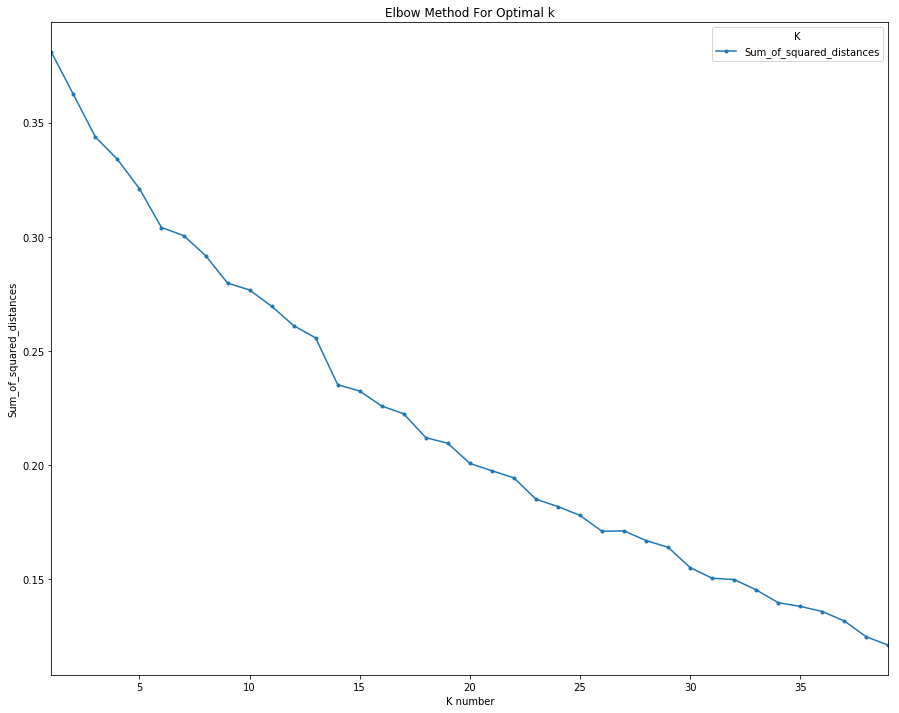

In [178]:
optimal_k.plot(kind = 'line', figsize = (15, 12), marker = '.')
plt.xlabel('K number')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Thank you!